In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

2025-07-08 20:03:59.615364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752005039.814374      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752005039.877875      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = 227
BATCH_SIZE = 32
EPOCHS = 16
LEARNING_RATE = 1e-5

DICOM_DATA_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
LABELS_CSV = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
PNG_OUTPUT_DIR = "/kaggle/working/rsna_pneumonia_png_images"

os.makedirs(PNG_OUTPUT_DIR, exist_ok=True)

# --- DICOM'dan PNG'ye dönüşüm (senin verdiğin kodla aynı) ---
df_labels = pd.read_csv(LABELS_CSV)
patient_ids = df_labels['patientId'].unique()

print(f"{len(patient_ids)} adet DICOM dosyası PNG'ye dönüştürülüyor...")

for i, patient_id in enumerate(patient_ids):
    dicom_path = os.path.join(DICOM_DATA_DIR, patient_id + ".dcm")
    output_path = os.path.join(PNG_OUTPUT_DIR, patient_id + ".png")

    if os.path.exists(output_path):
        continue

    try:
        dicom = pydicom.dcmread(dicom_path)
        img = dicom.pixel_array.astype(np.float32)

        if 'WindowCenter' in dicom and 'WindowWidth' in dicom:
            window_center = dicom.WindowCenter
            window_width = dicom.WindowWidth
            if isinstance(window_center, pydicom.multival.MultiValue):
                window_center = window_center[0]
            if isinstance(window_width, pydicom.multival.MultiValue):
                window_width = window_width[0]

            min_val = window_center - window_width / 2
            max_val = window_center + window_width / 2

            img = np.clip(img, min_val, max_val)
            img = ((img - min_val) / (max_val - min_val + 1e-5)) * 255
        else:
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5) * 255

        img = img.astype(np.uint8)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        cv2.imwrite(output_path, img)

    except Exception as e:
        print(f"Hata: {patient_id}.dcm dönüştürülürken hata oluştu: {e}")
        continue

    if (i + 1) % 1000 == 0:
        print(f"{i + 1} görüntü dönüştürüldü.")

print("Tüm DICOM dosyaları PNG'ye dönüştürüldü.")

26684 adet DICOM dosyası PNG'ye dönüştürülüyor...
1000 görüntü dönüştürüldü.
2000 görüntü dönüştürüldü.
3000 görüntü dönüştürüldü.
4000 görüntü dönüştürüldü.
5000 görüntü dönüştürüldü.
6000 görüntü dönüştürüldü.
7000 görüntü dönüştürüldü.
8000 görüntü dönüştürüldü.
9000 görüntü dönüştürüldü.
10000 görüntü dönüştürüldü.
11000 görüntü dönüştürüldü.
12000 görüntü dönüştürüldü.
13000 görüntü dönüştürüldü.
14000 görüntü dönüştürüldü.
15000 görüntü dönüştürüldü.
16000 görüntü dönüştürüldü.
17000 görüntü dönüştürüldü.
18000 görüntü dönüştürüldü.
19000 görüntü dönüştürüldü.
20000 görüntü dönüştürüldü.
21000 görüntü dönüştürüldü.
22000 görüntü dönüştürüldü.
23000 görüntü dönüştürüldü.
24000 görüntü dönüştürüldü.
25000 görüntü dönüştürüldü.
26000 görüntü dönüştürüldü.
Tüm DICOM dosyaları PNG'ye dönüştürüldü.


In [3]:
# --- Veri setini hazırla ---
df_labels['filename'] = df_labels['patientId'] + ".png"
df_labels['Target'] = df_labels['Target'].astype(str)

train_val_df, test_df = train_test_split(df_labels, test_size=0.2, stratify=df_labels["Target"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df["Target"], random_state=42)

print(f"Eğitim seti boyutu: {len(train_df)}")
print(f"Doğrulama seti boyutu: {len(val_df)}")
print(f"Test seti boyutu: {len(test_df)}")

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df["Target"]), y=train_df["Target"])
class_weights = dict(enumerate(class_weights))
print("Sınıf Ağırlıkları (Class Weights):", class_weights)

Eğitim seti boyutu: 21762
Doğrulama seti boyutu: 2419
Test seti boyutu: 6046
Sınıf Ağırlıkları (Class Weights): {0: 0.7311026002822012, 1: 1.5817706061927606}


In [4]:
# --- TF Dataset fonksiyonu ---
def process_path(filename, label):
    img_path = tf.strings.join([PNG_OUTPUT_DIR, "/", filename])
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)  # Gri tonlama
    img = tf.image.grayscale_to_rgb(img)    # 3 kanal yapıyoruz
    img = tf.image.convert_image_dtype(img, tf.float32)  # 0-1 arası normalize

    # Veri artırma (sadece eğitim için)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_zoom(img, (0.85, 1.15)) if hasattr(tf.image, "random_zoom") else img  # TF 2.10 ve üzeri için, değilse silebilirsin
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    return img, label

def process_path_no_aug(filename, label):
    img_path = tf.strings.join([PNG_OUTPUT_DIR, "/", filename])
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

In [5]:
# Label'ları int yapıyoruz
train_labels = train_df['Target'].astype(int).values
val_labels = val_df['Target'].astype(int).values
test_labels = test_df['Target'].astype(int).values

train_ds = tf.data.Dataset.from_tensor_slices((train_df['filename'].values, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['filename'].values, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['filename'].values, test_labels))

train_ds = train_ds.shuffle(1000).map(process_path, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path_no_aug, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path_no_aug, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


I0000 00:00:1752005655.089388      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
def build_vgg16_from_scratch(input_shape=(IMG_SIZE, IMG_SIZE, 3)):

    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same',input_shape=input_shape))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 2
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 3
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 4
    model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 5
    model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation='relu'))

    model.add(layers.Dense(4096, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid', dtype='float32'))

    return model

model = build_vgg16_from_scratch()

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacklar
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Model özet
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 227, 227, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 227, 227, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 113, 113, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 113, 113, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 134,264,641 (512.18 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# --- Modeli eğit ---
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/16


I0000 00:00:1752005664.186281      96 service.cc:148] XLA service 0x7e551401b920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752005664.187240      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752005664.973315      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752005685.354203      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


681/681 ━━━━━━━━━━━━━━━━━━━━ 217s 277ms/step - accuracy: 0.6282 - loss: 0.5970 - val_accuracy: 0.7846 - val_loss: 0.4617 - learning_rate: 1.0000e-05
Epoch 2/16
681/681 ━━━━━━━━━━━━━━━━━━━━ 170s 250ms/step - accuracy: 0.7490 - loss: 0.5239 - val_accuracy: 0.7830 - val_loss: 0.4719 - learning_rate: 1.0000e-05
Epoch 3/16
680/681 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7572 - loss: 0.5129
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
681/681 ━━━━━━━━━━━━━━━━━━━━ 170s 250ms/step - accuracy: 0.7572 - loss: 0.5128 - val_accuracy: 0.7668 - val_loss: 0.4998 - learning_rate: 1.0000e-05
Epoch 4/16
681/681 ━━━━━━━━━━━━━━━━━━━━ 171s 251ms/step - accuracy: 0.7610 - loss: 0.5034 - val_accuracy: 0.7933 - val_loss: 0.4506 - learning_rate: 5.0000e-06
Epoch 5/16
681/681 ━━━━━━━━━━━━━━━━━━━━ 170s 250ms/step - accuracy: 0.7589 - loss: 0.5018 - val_accuracy: 0.7702 - val_loss: 0.4863 - learning_rate: 5.0000e-06
Epoch 6/16
680/681 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - ac

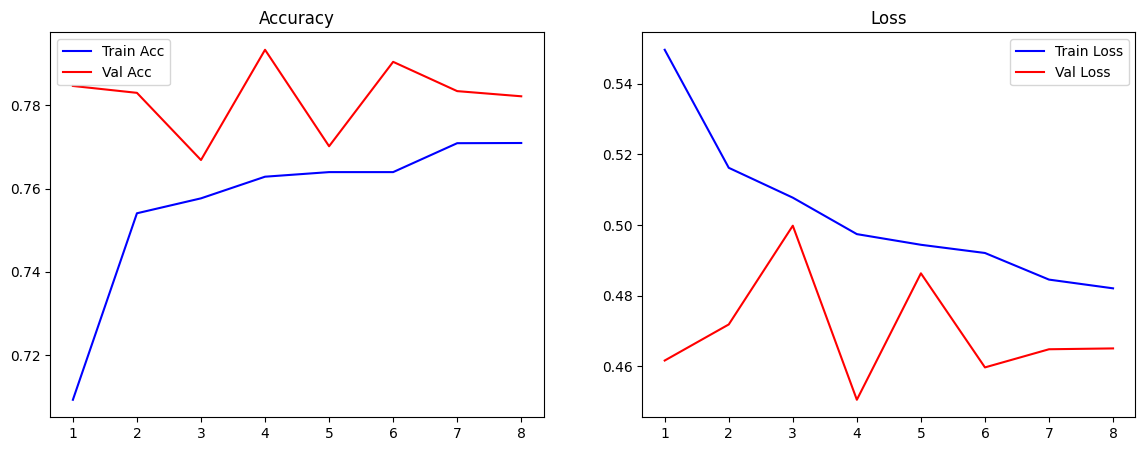

In [8]:
import matplotlib.pyplot as plt
def plot_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Acc')
    plt.plot(epochs, val_acc, 'r-', label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)


In [9]:
# Gerçek etiketleri ve tahminleri toplamak için listeler
y_true = []
y_pred_probs = []

# Dataset'ten verileri çek
for batch in val_ds:
    X_batch, y_batch = batch
    y_true.extend(y_batch.numpy())  # Gerçek etiketleri topla
    preds = model.predict(X_batch, verbose=0)  # Tahmin olasılıkları
    y_pred_probs.extend(preds)

# Listeyi numpy dizisine çevir
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrikleri hesapla
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_probs)

print(f"🔹 Accuracy     : {acc:.4f}")
print(f"🔹 Precision    : {prec:.4f}")
print(f"🔹 Recall       : {rec:.4f}")
print(f"🔹 F1-Score     : {f1:.4f}")
print(f"🔹 ROC AUC      : {roc_auc:.4f}")


🔹 Accuracy     : 0.7933
🔹 Precision    : 0.6546
🔹 Recall       : 0.7333
🔹 F1-Score     : 0.6917
🔹 ROC AUC      : 0.8529
